In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

/Users/pradyumna/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(23) # from random.org

# 3.1. Hierarchical GLAM estimation and out of sample prediction

## Load data

In [3]:
# Load data
sufix = '_Dislike_FixBin5'
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Dislike_Bin_v2.csv')
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,1,3327,0.0,5.0,0.745415,0.254585
1,0,1,1,3424,5.0,4.0,0.410720,0.589280
2,0,2,1,3691,4.0,1.0,0.330549,0.669451
3,0,3,0,8144,3.0,5.0,0.592345,0.407655
4,0,4,0,6559,5.0,5.0,0.641717,0.358283


## Split data in training and test sets

In [4]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1980 trials) and test (1980 trials) sets...


## Hierarchical GLAM estimation

### 1. full GLAM

In [5]:
# Fitting full GLAM
print('Fitting full GLAM hierarchically...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy')):
    glam_full.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='ADVI', n_advi=200000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   
# Save parameter estimates
np.save(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

Fitting full GLAM hierarchically...
  Found old parameter estimates in "results/estimates". Skipping estimation...


ValueError: Must pass 2-d input

In [6]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1980 trials) with new data (1980 trials)...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,1.0,0.0,2486.0,0.0,0.0,5.0,0.41072,4.0,0.58928
1,0.0,1.0,2946.0,0.0,0.0,5.0,0.41072,4.0,0.58928
2,1.0,2.0,6671.0,0.0,0.0,5.0,0.41072,4.0,0.58928
3,1.0,3.0,5131.0,0.0,0.0,5.0,0.41072,4.0,0.58928
4,1.0,4.0,5295.0,0.0,0.0,5.0,0.41072,4.0,0.58928


### 1. no-bias GLAM

In [7]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM hierarchically...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy')):
    glam_nobias.make_model('hierarchical', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='ADVI', n_advi=200000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'))
    
# Save parameter estimates
np.save(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'), glam_nobias.estimates)
pd.DataFrame(glam_nobias.estimates)

Fitting no-bias GLAM hierarchically...
Generating hierarchical model for 33 subjects...
Fitting 1 model(s) using ADVI...
  Fitting model 1 of 1...


Average Loss = 18,429: 100%|██████████| 200000/200000 [13:34<00:00, 245.63it/s]
Finished [100%]: Average Loss = 18,429


/!\ Automatically setting parameter precision...


,SNR,SNR_mu,SNR_sd,b,gamma,p_error,s,t0,tau,tau_mu,tau_sd,v,v_mu,v_sd
0,172.47,169.06,22.12,1.0,1.0,0.05,0.007749,0.0,0.00,0.02,0.03,0.000043,0.000053,0.00001
1,175.16,169.06,22.12,1.0,1.0,0.05,0.009738,0.0,0.01,0.02,0.03,0.000055,0.000053,0.00001
2,162.81,169.06,22.12,1.0,1.0,0.05,0.007997,0.0,0.01,0.02,0.03,0.000050,0.000053,0.00001
3,181.21,169.06,22.12,1.0,1.0,0.05,0.008427,0.0,0.01,0.02,0.03,0.000047,0.000053,0.00001
4,192.35,169.06,22.12,1.0,1.0,0.05,0.011280,0.0,0.01,0.02,0.03,0.000059,0.000053,0.00001
5,161.24,169.06,22.12,1.0,1.0,0.05,0.008938,0.0,0.01,0.02,0.03,0.000055,0.000053,0.00001
6,162.48,169.06,22.12,1.0,1.0,0.05,0.009802,0.0,0.01,0.02,0.03,0.000060,0.000053,0.00001
7,155.41,169.06,22.12,1.0,1.0,0.05,0.007936,0.0,0.01,0.02,0.03,0.000052,0.000053,0.00001
8,162.50,169.06,22.12,1.0,1.0,0.05,0.009011,0.0,0.01,0.02,0.03,0.000053,0.000053,0.00001
9,150.23,169.06,22.12,1.0,1.0,0.05,0.010010,0.0,0.01,0.02,0.03,0.000060,0.000053,0.00001


In [8]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv')):
    glam_nobias.predict(n_repeats=50)
    glam_nobias.prediction.to_csv(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...')
    glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv'))

glam_nobias.prediction.head()

Predicting test set data using no-bias GLAM...
Replaced attached data (1980 trials) with new data (1980 trials)...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,2178.0,0.0,0.0,5.0,0.41072,4.0,0.58928
1,1.0,1.0,2721.0,0.0,0.0,5.0,0.41072,4.0,0.58928
2,1.0,2.0,1760.0,0.0,0.0,5.0,0.41072,4.0,0.58928
3,1.0,3.0,3120.0,0.0,0.0,5.0,0.41072,4.0,0.58928
4,1.0,4.0,4892.0,0.0,0.0,5.0,0.41072,4.0,0.58928


## 2. Plot fit

Close Figure to continue...


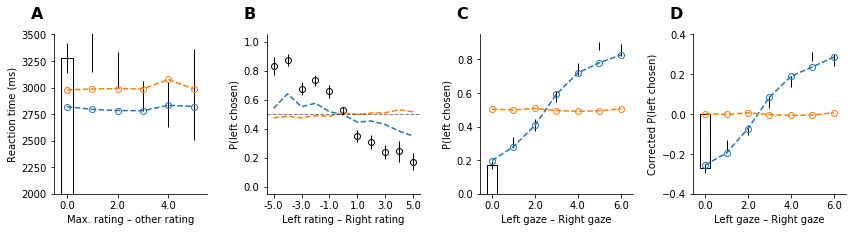

In [9]:
print('Close Figure to continue...')
#glam.plot_fit(test_data, [glam_full.prediction]);
glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## Parameters for full hierarchical model

In [10]:
params_part = glam_full.estimates.item(0)
params_part = pd.DataFrame.from_dict(glam_full.estimates.item(0))

AttributeError: 'dict' object has no attribute 'item'

In [ ]:
params_part

## [END] 

In [ ]:
testa = glam_nobias.prediction

In [ ]:
xlims =(0, 10)

# Compute relevant variables
df = glam.plots.add_difficulty(testa)

# Compute summary statistics
subject_means = df.groupby(['subject', 'difficulty']).rt.mean()
means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]


In [ ]:
means